In [1]:
%matplotlib inline
import os
import os.path as osp
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from snorkel import SnorkelSession
from snorkel.models import Candidate, Label, LabelKey
from tcre import supervision
from tcre import labeling
from tcre.supervision import SPLIT_DEV, SPLIT_TEST, SPLIT_VAL, SPLIT_TRAIN, SPLIT_MAP
from tcre.env import *
session = SnorkelSession()
classes = supervision.get_candidate_classes()

STR_SUP_INFIX = '_ssup_'

In [2]:
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-lfs', 'run1')
output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-lfs', 'run2') # Adding parse tree LFs
output_dir

'/lab/data/results/modeling-lfs/run2'

### Splits

In [3]:
from tcre.modeling import sampling

def get_splits_file(task):
    return osp.join(output_dir, task, 'splits', 'splits.json')

# DB splits -> modeling splits 
TARGET_MAP = {'dev': 'train', 'val': 'val', 'test': 'test'}
df_cand, df_dist = sampling.get_modeling_splits(session, target_split_map=TARGET_MAP)

# Write splits to file
for task, g in df_cand.groupby('task'):
    splits = g.groupby('split')['id'].unique()
    splits_file = get_splits_file(task)
    os.makedirs(osp.dirname(splits_file), exist_ok=True)
    splits.to_json(splits_file, orient='index')
    print(f'Splits for task {task} written to "{splits_file}"')
    
df_dist

Splits for task inducing_cytokine written to "/lab/data/results/modeling-lfs/run2/inducing_cytokine/splits/splits.json"
Splits for task inducing_transcription_factor written to "/lab/data/results/modeling-lfs/run2/inducing_transcription_factor/splits/splits.json"
Splits for task secreted_cytokine written to "/lab/data/results/modeling-lfs/run2/secreted_cytokine/splits/splits.json"


statistic                           percent       count     
label                                     0     1     0    1
task                          split                         
inducing_cytokine             test     50.0  50.0    29   29
                              train    50.0  50.0   145  145
                              val      50.0  50.0    23   23
inducing_transcription_factor test     50.0  50.0    58   58
                              train    50.0  50.0   107  107
                              val      50.0  50.0    44   44
secreted_cytokine             test     50.0  50.0    64   64
                              train    50.0  50.0   131  131
                              val      50.0  50.0    49   49

In [4]:
df_cand.groupby(['task', 'split']).size().unstack()

split,test,train,val
task,,,
inducing_cytokine,58,290,46
inducing_transcription_factor,116,214,88
secreted_cytokine,128,262,98


### Initialization

In [5]:
# Get all LabelKey names NOT related to strong supervision (they will be added as a result of this process)
candidate_class_key_names = {
    c: {k.id: k.name for k in labeling.get_labels_keys(session, classes[c]) if STR_SUP_INFIX not in k.name}
    for c in classes
}
pd.Series({k: list(v.values()) for k, v in candidate_class_key_names.items()}).apply(pd.Series).T

,InducingCytokine,SecretedCytokine,InducingTranscriptionFactor
0,LF_indck_comp_imexpresso_nonneg,LF_secck_comp_imexpresso_nonneg,LF_indtf_comp_xor
1,LF_indck_comp_neg_sec,LF_secck_comp_neg_ind,LF_indtf_heur_closer_ct_to_tf
2,LF_indck_comp_xor,LF_secck_comp_xor,LF_indtf_heur_closer_ref
3,LF_indck_dsup_imexpresso_mp04,LF_secck_dsup_imexpresso_mp04,LF_indtf_heur_closer_tf_to_ct
4,LF_indck_dsup_imexpresso_mp08,LF_secck_dsup_imexpresso_mp08,LF_indtf_heur_complex_cand_01
5,LF_indck_dsup_imexpresso_mp12,LF_secck_dsup_imexpresso_mp12,LF_indtf_heur_complex_cand_02
6,LF_indck_dsup_imexpresso_mp20,LF_secck_dsup_imexpresso_mp20,LF_indtf_heur_distref
7,LF_indck_heur_closer_ck_to_ct,LF_secck_heur_closer_ck_to_ct,LF_indtf_heur_distref_10
8,LF_indck_heur_closer_ct_to_ck,LF_secck_heur_closer_ct_to_ck,LF_indtf_heur_distref_15
9,LF_indck_heur_closer_ref,LF_secck_heur_closer_ref,LF_indtf_heur_distref_20


In [6]:
from snorkel.annotations import load_label_matrix
from snorkel.learning.utils import LabelBalancer

def get_features(candidate_class, split):
    # Get {id -> name} dict of label keys for this class
    keys = candidate_class_key_names[candidate_class.name]
    X = labeling.get_labels_matrix(session, candidate_class, split, key_names=list(keys.values()))
    index = [X.row_index[i] for i in np.arange(X.shape[0])]
    columns = [keys[X.col_index[i]] for i in np.arange(X.shape[1])]
    df = pd.DataFrame(X.toarray(), columns=columns, index=index)
    df = df[sorted([c for c in df.columns.tolist()])]
    return df

def get_feature_names(candidate_class):
    return get_features(candidate_class, SPLIT_DEV).columns.to_list()

def get_labels(candidate_class, split):
    y = supervision.get_gold_labels(session, candidate_class, split)
    return y

def get_split_ids(candidate_class, split):
    splits = pd.read_json(get_splits_file(candidate_class.field), typ='series', orient='index')
    # Convert Snorkel split id to training split name and fetch ids with it
    return splits[TARGET_MAP[SPLIT_MAP[split]]]

def get_data(candidate_class, split):
    X, y = get_features(candidate_class, split), get_labels(candidate_class, split).map({-1:0, 1:1})
    ids = get_split_ids(candidate_class, split)
    assert y.notnull().all()
    assert np.all(X.index == y.index)
    # Subset to target ids for this split
    X, y = X.loc[ids], y.loc[ids]
    assert np.all(X.index == y.index)
    return X, y

In [7]:
X, y = get_data(classes.inducing_cytokine, SPLIT_DEV)
print(X.shape, y.shape)
y.value_counts()

(290, 32) (290,)


1    145
0    145
dtype: int64

In [8]:
get_feature_names(classes.inducing_cytokine)[:5]

['LF_indck_comp_imexpresso_nonneg',
 'LF_indck_comp_neg_sec',
 'LF_indck_comp_xor',
 'LF_indck_dsup_imexpresso_mp04',
 'LF_indck_dsup_imexpresso_mp08']

### Training

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from tcre.modeling.models import estimators 
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score

def run_modeling(X, y, est):
    get_data(candidate_class, split, balance=.5)
    
def get_cv_data(data):
    n_dev, n_val = len(data[SPLIT_DEV][0]), len(data[SPLIT_VAL][0])
    X_train = pd.concat([data[SPLIT_DEV][0], data[SPLIT_VAL][0]])
    y_train = pd.concat([data[SPLIT_DEV][1], data[SPLIT_VAL][1]])
    X_test, y_test = data[SPLIT_TEST][0], data[SPLIT_TEST][1]
    X_val, y_val = data[SPLIT_VAL][0], data[SPLIT_VAL][1]
    X_dev, y_dev = data[SPLIT_DEV][0], data[SPLIT_DEV][1]
    
    # Creating single fold with DEV as training and VAL as test
    fold = np.zeros(n_dev + n_val, dtype=int)
    fold[:n_dev] = -1
    cv = PredefinedSplit(fold)
    assert cv.get_n_splits() == 1
    return (X_train, y_train, X_test, y_test, X_val, y_val, X_dev, y_dev), cv


def get_scores(y_true, y_pred, y_proba):
    return {
        'f1': f1_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'pr_auc': average_precision_score(y_true, y_proba)
    }
    
def process(candidate_class):
    splits = [SPLIT_DEV, SPLIT_VAL, SPLIT_TEST]
    data = {split: get_data(candidate_class, split) for split in splits}
    (X_train, y_train, X_test, y_test, X_val, y_val, X_dev, y_dev), cv = get_cv_data(data)
    ests = estimators.get_estimators(cv)
    res = []
    
    def score(est, X, y):
        y_pred = est.predict(X)
        y_proba = est.predict_proba(X)
        assert y_proba.ndim == 2
        assert y_proba.shape[1] == 2
        y_proba = y_proba[:, 1]
        return get_scores(y, y_pred, y_proba)
        
    for k, est in ests.items():
        print(f'Processing model {k} for class {candidate_class.field}')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=ConvergenceWarning)
            est = est.fit(X_train, y_train)
        res.append(dict(
            task=candidate_class.field, est_name=k, est=est,
            training_scores=score(est, X_dev, y_dev),
            validation_scores=score(est, X_val, y_val), 
            test_scores=score(est, X_test, y_test)
        ))
    return res

In [11]:
res = [
    r 
    for c in classes
    for r in process(classes[c])
]

Processing model gbr for class inducing_cytokine
Processing model xgb for class inducing_cytokine
Processing model ridge for class inducing_cytokine
Processing model ridge2 for class inducing_cytokine
Processing model lasso for class inducing_cytokine
Processing model lasso2 for class inducing_cytokine


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Processing model gbr for class secreted_cytokine
Processing model xgb for class secreted_cytokine
Processing model ridge for class secreted_cytokine
Processing model ridge2 for class secreted_cytokine
Processing model lasso for class secreted_cytokine
Processing model lasso2 for class secreted_cytokine


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Processing model gbr for class inducing_transcription_factor
Processing model xgb for class inducing_transcription_factor
Processing model ridge for class inducing_transcription_factor
Processing model ridge2 for class inducing_transcription_factor
Processing model lasso for class inducing_transcription_factor
Processing model lasso2 for class inducing_transcription_factor


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Labeling Function (Feature) Importance

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

def get_feature_importance(res):
    res = [r for r in res if isinstance(r['est'], GridSearchCV) and isinstance(r['est'].best_estimator_, GradientBoostingClassifier)]
    imps = {}
    for r in res:
        est = r['est'].best_estimator_
        candidate_class = {classes[c].field: classes[c] for c in classes}[r['task']]
        imps[r['task']] = pd.Series(est.feature_importances_, get_feature_names(candidate_class))
    return imps

In [13]:
imps = get_feature_importance(res)

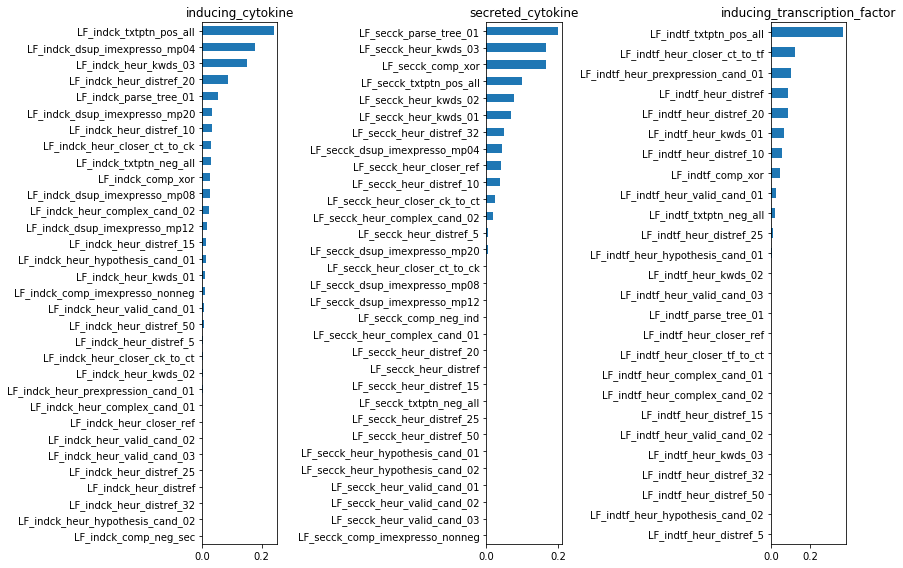

In [14]:
fig, axs = plt.subplots(1, len(imps))
fig.set_size_inches(4 * len(imps), 8)
for i, (k, v) in enumerate(imps.items()):
    v.sort_values().plot.barh(title=k, ax=axs[i])
plt.tight_layout()

In [15]:
dfs = pd.concat([
    pd.DataFrame([
        pd.Series(dict(task=r['task'], est_name=r['est_name'], split=split)).append(pd.Series(r[split + '_scores']))
        for r in res
    ])
    for split in ['validation', 'test', 'training']
])
dfs.head()

,task,est_name,split,f1,accuracy,precision,recall,roc_auc,pr_auc
0,inducing_cytokine,gbr,validation,0.727273,0.739130,0.761905,0.695652,0.880907,0.904527
1,inducing_cytokine,xgb,validation,0.755556,0.760870,0.772727,0.739130,0.822306,0.847882
2,inducing_cytokine,ridge,validation,0.765957,0.760870,0.750000,0.782609,0.877127,0.894768
3,inducing_cytokine,ridge2,validation,0.800000,0.804348,0.818182,0.782609,0.886578,0.923220
4,inducing_cytokine,lasso,validation,0.755556,0.760870,0.772727,0.739130,0.829868,0.851611


In [16]:
dfs

,task,est_name,split,f1,accuracy,precision,recall,roc_auc,pr_auc
0,inducing_cytokine,gbr,validation,0.727273,0.739130,0.761905,0.695652,0.880907,0.904527
1,inducing_cytokine,xgb,validation,0.755556,0.760870,0.772727,0.739130,0.822306,0.847882
2,inducing_cytokine,ridge,validation,0.765957,0.760870,0.750000,0.782609,0.877127,0.894768
3,inducing_cytokine,ridge2,validation,0.800000,0.804348,0.818182,0.782609,0.886578,0.923220
4,inducing_cytokine,lasso,validation,0.755556,0.760870,0.772727,0.739130,0.829868,0.851611
5,inducing_cytokine,lasso2,validation,0.800000,0.804348,0.818182,0.782609,0.840265,0.851160
6,secreted_cytokine,gbr,validation,0.784314,0.775510,0.754717,0.816327,0.868596,0.843475
7,secreted_cytokine,xgb,validation,0.767677,0.765306,0.760000,0.775510,0.841733,0.809597
8,secreted_cytokine,ridge,validation,0.803922,0.795918,0.773585,0.836735,0.883798,0.845344
9,secreted_cytokine,ridge2,validation,0.870370,0.857143,0.796610,0.959184,0.909204,0.909098


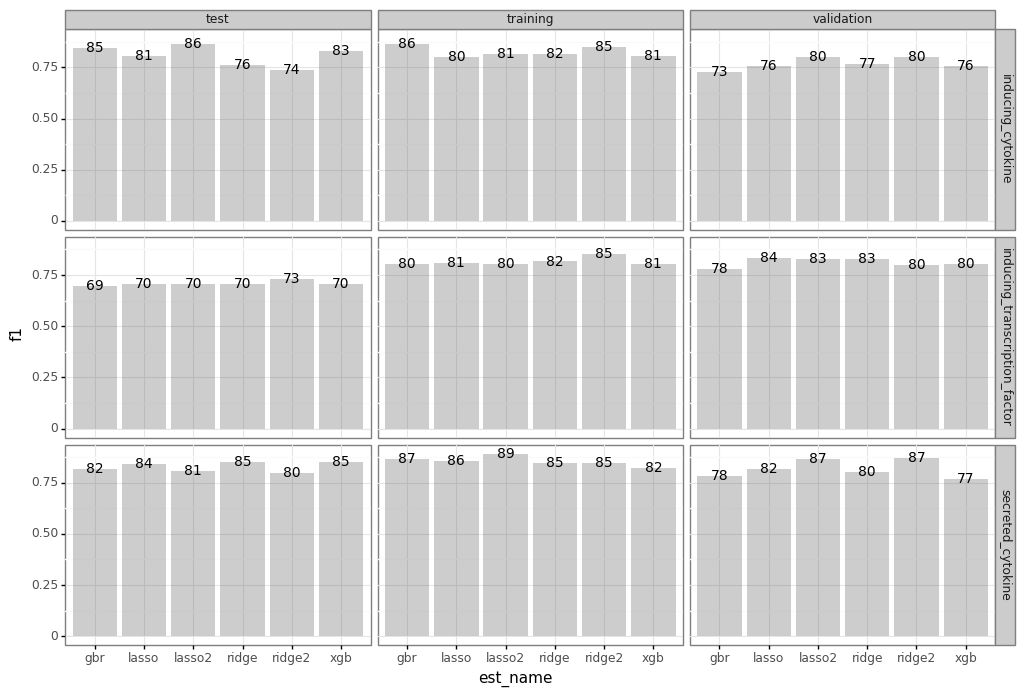

<ggplot: (8727094632200)>

In [17]:
(
    pn.ggplot(
        dfs.assign(label=lambda df: df['f1'].apply(lambda v: '{:.0f}'.format(100*v))),
        pn.aes(x='est_name', y='f1', label='label')
    ) + 
    pn.geom_bar(stat='identity', alpha=.3) + 
    pn.geom_text(size=10) + 
    pn.facet_grid('task ~ split') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(12, 8))
)

### Train Split Labels

This section will take the models trained on the ```dev``` split above and apply them to produce labeling function values on all splits:

In [18]:
# First build a dict mapping candidate ids to predictions for each task

pred_labels = collections.defaultdict(lambda: collections.defaultdict(lambda: {}))
for c in classes:
    for split in [SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN]:
        print(f'Collecting predictions for task={classes[c].field}, split={SPLIT_MAP[split]} [{split}]')
        X = get_features(classes[c], split)
        cand_ids = list(X.index.values)
        for r in [r for r in res if r['task'] == classes[c].field]:
            y_pred = r['est'].predict(X)
            assert y_pred.ndim == 1
            assert np.all(np.in1d(y_pred, [0, 1]))
            y_pred = [{0: -1, 1:1}[v] for v in y_pred]
            assert len(y_pred) == len(cand_ids)
            pred_labels[c][split][r['est_name']] = dict(zip(cand_ids, y_pred))
        
pd.DataFrame([
    dict(task=classes[c].field, est=e, split=s, n=len(pred_labels[c][s][e]))
    for c in pred_labels
    for s in pred_labels[c]
    for e in pred_labels[c][s]
]).pivot_table(index=['task', 'split'], columns=['est'], values=['n'])

n                                   
est                                    gbr  lasso lasso2  ridge ridge2    xgb
task                          split                                          
inducing_cytokine             0      10000  10000  10000  10000  10000  10000
                              1       1025   1025   1025   1025   1025   1025
                              2        371    371    371    371    371    371
                              3        278    278    278    278    278    278
inducing_transcription_factor 0      10000  10000  10000  10000  10000  10000
                              1        627    627    627    627    627    627
                              2        300    300    300    300    300    300
                              3        225    225    225    225    225    225
secreted_cytokine             0      10000  10000  10000  10000  10000  10000
                              1       1019   1019   1019   1019   1019   1019
                              2        364    364    364    364    364    364
                              3        272    272    272    272    272    272

In [19]:
# Next remove any existing labels relating to strong supervision

def get_label_keys(session, key_group=None):
    query = session.query(LabelKey)
    if key_group is not None:
        query = query.filter(LabelKey.group == key_group)
    return [k for k in query.all() if STR_SUP_INFIX in k.name]

def clear_existing_labels(session):
    from snorkel.models import LabelKey, Label
    
    # Get all LabelKey instances related to strong supervision (regardless of task) 
    rm_keys = get_label_keys(session)
    rm_key_ids = frozenset([k.id for k in rm_keys])
    
    def get_num_labels():
        return session.query(Label).filter(Label.key_id.in_(rm_key_ids)).count()
    
    # Fetch number of Label instances associated with keys to delete
    ct_before = get_num_labels()
    
    session.query(LabelKey).filter(LabelKey.id.in_(rm_key_ids)).delete(synchronize_session='fetch')
    session.commit()

    # Fetch number of Label instances again, after cascaded deletion
    ct_after = get_num_labels()
    return ct_before, ct_after
    

In [20]:
clear_existing_labels(session)

(0, 0)

In [21]:
def get_lf_name(candidate_class, est_name):
    return 'LF_{}{}{}'.format(candidate_class.abbr, STR_SUP_INFIX, est_name)

est_names = list(set([r['est_name'] for r in res]))
lf_names = {
    c: [get_lf_name(classes[c], e) for e in est_names]
    for c in classes
}
pd.set_option('display.max_colwidth', 200)
pd.Series(lf_names)

InducingCytokine               [LF_indck_ssup_lasso2, LF_indck_ssup_ridge2, LF_indck_ssup_lasso, LF_indck_ssup_gbr, LF_indck_ssup_xgb, LF_indck_ssup_ridge]
SecretedCytokine               [LF_secck_ssup_lasso2, LF_secck_ssup_ridge2, LF_secck_ssup_lasso, LF_secck_ssup_gbr, LF_secck_ssup_xgb, LF_secck_ssup_ridge]
InducingTranscriptionFactor    [LF_indtf_ssup_lasso2, LF_indtf_ssup_ridge2, LF_indtf_ssup_lasso, LF_indtf_ssup_gbr, LF_indtf_ssup_xgb, LF_indtf_ssup_ridge]
dtype: object

In [22]:
# labeling.annotation_keys_exist(session, classes.secreted_cytokine, LabelKey, key_names=lf_names[classes.secreted_cytokine.name])

In [23]:
# Add the above predictions to the DB as Label instances
res_label = collections.defaultdict(lambda: collections.defaultdict(lambda: {}))
for c in pred_labels:
    for split in pred_labels[c]:
        est_pred = pred_labels[c][split]
        
        # Create function to produce list of lf_name, value pairs for each candidate
        def label_generator(cand):
            res = []
            for est_name in est_pred:
                pred_map = est_pred[est_name]
                label_name = get_lf_name(classes[c], est_name)
                if cand.id not in pred_map:
                    raise ValueError(f'Failed to find prediction for candidate={cand.id}, estimator={est_name}, task={classes[c].field}')
                value = pred_map[cand.id]
                assert value in [-1, 1]
                res.append((label_name, value))
            return res

        print(f'Adding predicted labels for task {classes[c].field} (split = {SPLIT_MAP[split]} [{split}])')
        # Be sure to scope all key existence operations to a static list of key names since other non-supervision keys already exist.
        # If not done correctly, then either keys will be inserted when they already exist causing IntegrityErrors or the keys will
        # never be created in the first place and the labels will all be unreachable
        key_names = lf_names[c]
        res_label[c][split] = labeling.apply_labeling_functions(session, classes[c], split, label_generator=label_generator, key_names=key_names)

  2%|▏         | 21/1025 [00:00<00:04, 208.69it/s]

Adding predicted labels for task inducing_cytokine (split = dev [1])
Running UDF...


  7%|▋         | 20/278 [00:00<00:01, 194.68it/s]

Adding predicted labels for task inducing_cytokine (split = val [3])
Running UDF...


  6%|▌         | 21/371 [00:00<00:01, 200.00it/s]

Adding predicted labels for task inducing_cytokine (split = test [2])
Running UDF...


  0%|          | 21/10000 [00:00<00:49, 201.10it/s]

Adding predicted labels for task inducing_cytokine (split = train [0])
Running UDF...


  2%|▏         | 24/1019 [00:00<00:04, 236.96it/s]

Adding predicted labels for task secreted_cytokine (split = dev [1])
Running UDF...


  7%|▋         | 20/272 [00:00<00:01, 198.30it/s]

Adding predicted labels for task secreted_cytokine (split = val [3])
Running UDF...


  5%|▌         | 19/364 [00:00<00:01, 185.13it/s]

Adding predicted labels for task secreted_cytokine (split = test [2])
Running UDF...


  0%|          | 20/10000 [00:00<00:52, 190.24it/s]

Adding predicted labels for task secreted_cytokine (split = train [0])
Running UDF...


  4%|▍         | 24/627 [00:00<00:02, 234.45it/s]

Adding predicted labels for task inducing_transcription_factor (split = dev [1])
Running UDF...


  8%|▊         | 19/225 [00:00<00:01, 185.79it/s]

Adding predicted labels for task inducing_transcription_factor (split = val [3])
Running UDF...


  7%|▋         | 20/300 [00:00<00:01, 190.50it/s]

Adding predicted labels for task inducing_transcription_factor (split = test [2])
Running UDF...


  0%|          | 20/10000 [00:00<00:52, 190.15it/s]

Adding predicted labels for task inducing_transcription_factor (split = train [0])
Running UDF...


100%|██████████| 10000/10000 [00:53<00:00, 186.74it/s]


### Export

In [24]:
dfe = dfs.rename(columns={'est_name': 'model'}).set_index(['task', 'model', 'split']).rename_axis('metric', axis='columns').stack().rename('value').reset_index()
dfe.head()

,task,model,split,metric,value
0,inducing_cytokine,gbr,validation,f1,0.727273
1,inducing_cytokine,gbr,validation,accuracy,0.739130
2,inducing_cytokine,gbr,validation,precision,0.761905
3,inducing_cytokine,gbr,validation,recall,0.695652
4,inducing_cytokine,gbr,validation,roc_auc,0.880907


In [25]:
!ls $RESULTS_DATA_DIR

modeling-bert  modeling-rnn-strong  simulations
modeling-lfs   modeling-rnn-weak    training-dev


In [26]:
path = osp.join(output_dir, 'scores.csv')
os.makedirs(osp.dirname(path), exist_ok=True)
dfe.to_csv(path, index=False)
path

'/lab/data/results/modeling-lfs/run2/scores.csv'